# 패키지 로드 및 디렉토리 설정

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/data/dataset

Mounted at /content/drive
/content/drive/MyDrive/data/dataset


In [26]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [3]:
from keras import layers, models
from keras import Input
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics, callbacks
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import cv2
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras

In [4]:
plt.rc('font', family='NanumBarunGothic')

# 데이터 로드 및 분할

In [6]:
categories = os.listdir()[:-4]
num_labels = len(categories)
categories

['슬픔', '중립', '기쁨', '당황', '분노', '불안', '상처']

In [7]:
image_w = 100
image_h = 100
  
X = []
Y = []
  
for idex, categorie in enumerate(categories):
    label = idex
    image_dir = categorie + '/'
  
    for top, dir, f in os.walk(image_dir):
        for filename in f:
            img = cv2.imread(image_dir+filename) # cv2.IMREAD_GRAYSCALE : 흑백 처리
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB, dst = img) # RGB 변환
            img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])
            X.append(img/255)
            Y.append(label)
 
X = np.array(X)
Y = np.array(Y)
 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)

In [8]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1890, 100, 100, 3) (210, 100, 100, 3) (1890,) (210,)


In [17]:
train_input, val_input, train_target, val_target = train_test_split(X_train, Y_train, 
                                                                      test_size=0.1, random_state=41)

# 모델 사용

In [18]:
model = keras.Sequential() # 순서대로 구조 정의
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', 
                              padding = 'same', input_shape = train_input.shape[1:]))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(len(categories), activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [19]:
batch_size = 32
epochs = 50

data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(train_input, train_target, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_cb=callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb=callbacks.EarlyStopping(patience=2,restore_best_weights=True)

history = model.fit(train_input, train_target, batch_size=batch_size, epochs = epochs,
                        shuffle=True, validation_data=(val_input, val_target),
                        steps_per_epoch = steps_per_epoch,
                        callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/50
59/59 [==============================] - 2s 31ms/step - loss: 2.0504 - accuracy: 0.1424 - val_loss: 1.9474 - val_accuracy: 0.1005
Epoch 2/50
59/59 [==============================] - 1s 14ms/step - loss: 1.9295 - accuracy: 0.1929 - val_loss: 1.9537 - val_accuracy: 0.1693
Epoch 3/50
59/59 [==============================] - 1s 16ms/step - loss: 1.8310 - accuracy: 0.2654 - val_loss: 1.8325 - val_accuracy: 0.2751
Epoch 4/50
59/59 [==============================] - 1s 17ms/step - loss: 1.6093 - accuracy: 0.3869 - val_loss: 1.7013 - val_accuracy: 0.3386
Epoch 5/50
59/59 [==============================] - 1s 13ms/step - loss: 1.4086 - accuracy: 0.4632 - val_loss: 1.7023 - val_accuracy: 0.3492
Epoch 6/50
59/59 [==============================] - 1s 16ms/step - loss: 1.2211 - accuracy: 0.5454 - val_loss: 1.6115 - val_accuracy: 0.3280
Epoch 7/50
59/59 [==============================] - 1s 14ms/step - loss: 1.0200 - accuracy: 0.6298 - val_loss: 1.6885 - val_accuracy: 0.3862
Epoch 8/50
59

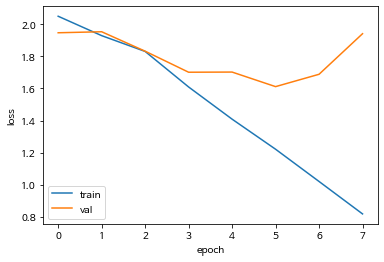

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [22]:
model.evaluate(val_input,val_target)

6/6 [==============================] - 0s 7ms/step - loss: 1.6115 - accuracy: 0.3280


[1.6115031242370605, 0.32804232835769653]

# 테스트 데이터 사용

In [23]:
X_test.shape, Y_test.shape

((210, 100, 100, 3), (210,))

In [24]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 16ms/step


In [25]:
y_pred = np.argmax(y_pred, 1)

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

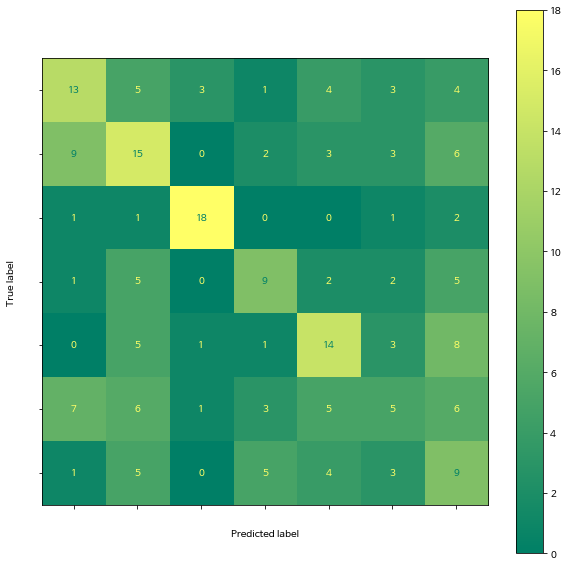

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

# 패키지 로드 및 전처리

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Input
from keras.models import Model
from keras.models  import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers, initializers, regularizers, metrics, callbacks
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
cifar10 = datasets.cifar10

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [4]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [5]:
train_images = train_images/255.0
test_images = test_images/255.0

In [6]:
x = np.concatenate((train_images, test_images))
y = np.concatenate((train_labels, test_labels))

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 42) # train / test 분할

In [7]:
train_input, val_input, train_target, val_target = train_test_split(x_train, y_train, test_size = 0.1,
                                                                    random_state = 42) # train / val 분할

In [8]:
print(train_input.shape, train_target.shape, val_input.shape, val_target.shape)

(48600, 32, 32, 3) (48600, 1) (5400, 32, 32, 3) (5400, 1)


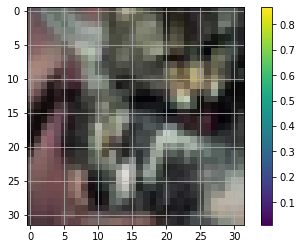

In [9]:
plt.figure()
plt.imshow(train_input[0])
plt.colorbar()
plt.grid(True)
plt.show()

# 최적의 dropout 탐색 및 모델 실행

In [10]:
batch_size = 512
num_classes = len(np.unique(train_target))
epochs = 50
lr = 1e-4
lr_weight_decay = 0.95

train_target = np_utils.to_categorical(train_target, num_classes) # one-hot vector로 변환
val_target = np_utils.to_categorical(val_target, num_classes)

In [ ]:
from keras import initializers
import copy

result = {}
y = {}
loss = []
accuracy = []

dropouts = [num/10 for num in range(10)]

for dropout in dropouts:
    print("Dropout : ", (dropout))
    model = Sequential()

    # layer 1
    model.add(Conv2D(64, 3, padding='same', activation='relu',input_shape=(train_input.shape[1:])))
    model.add(Dropout(dropout))  
    model.add(Conv2D(64, 3, activation='relu',padding='same'))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # layer 2
    model.add(Conv2D(128, 3, activation='relu',padding='same'))
    model.add(Dropout(dropout))                                        
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # layer 3                         
    model.add(Conv2D(256, 3, activation='relu',padding='same'))
    model.add(Dropout(dropout)) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # layer 4
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))

    # layer 5
    model.add(Dense(512, activation='relu'))

    # layer 6
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only = True)

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights = True)

    history = model.fit(train_input, train_target, batch_size=batch_size, epochs =epochs, verbose=1, 
                        shuffle=True, validation_data=(val_input, val_target),
                        callbacks = [checkpoint_cb, early_stopping_cb])
    
    score = model.evaluate(val_input, val_target, verbose=0)
    y[dropout] = model.predict(val_input)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    result[dropout] = copy.deepcopy(history.history)   
    loss.append(score[0])
    accuracy.append(score[1])

Dropout :  0.0
Epoch 1/50
95/95 [==============================] - 3s 21ms/step - loss: 1.6950 - accuracy: 0.3766 - val_loss: 1.3242 - val_accuracy: 0.5302
Epoch 2/50
95/95 [==============================] - 2s 17ms/step - loss: 1.1985 - accuracy: 0.5678 - val_loss: 1.0667 - val_accuracy: 0.6198
Epoch 3/50
95/95 [==============================] - 2s 17ms/step - loss: 0.9594 - accuracy: 0.6622 - val_loss: 0.8906 - val_accuracy: 0.6852
Epoch 4/50
95/95 [==============================] - 2s 17ms/step - loss: 0.7971 - accuracy: 0.7214 - val_loss: 0.7963 - val_accuracy: 0.7215
Epoch 5/50
95/95 [==============================] - 2s 17ms/step - loss: 0.6734 - accuracy: 0.7653 - val_loss: 0.7825 - val_accuracy: 0.7313
Epoch 6/50
95/95 [==============================] - 2s 20ms/step - loss: 0.5629 - accuracy: 0.8052 - val_loss: 0.7269 - val_accuracy: 0.7496
Epoch 7/50
95/95 [==============================] - 2s 17ms/step - loss: 0.4776 - accuracy: 0.8360 - val_loss: 0.7199 - val_accuracy: 0.757

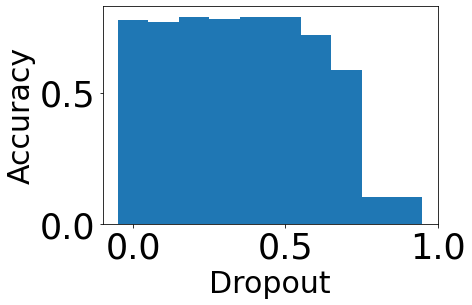

In [ ]:
import numpy as np                                                               
import matplotlib.pyplot as plt

# plt.figure(figsize = (13,10))
width = 0.1

plt.bar(dropouts, accuracy, width, align='center')

plt.tick_params(axis='both', which='major', labelsize=35)
plt.tick_params(axis='both', which='minor', labelsize=35)

plt.ylabel('Accuracy',size = 30)
plt.xlabel('Dropout', size = 30)
plt.show()

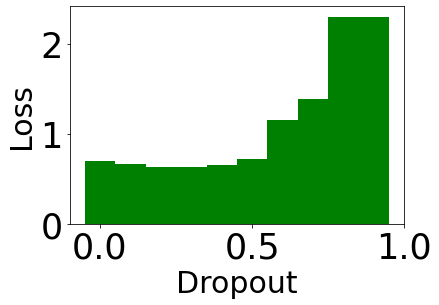

In [ ]:
width = 0.1

plt.bar(dropouts, loss, width, align='center',color = 'green')

plt.tick_params(axis='both', which='major', labelsize=35)
plt.tick_params(axis='both', which='minor', labelsize=35)

plt.ylabel('Loss',size = 30)
plt.xlabel('Dropout', size = 30)
plt.show()

- accuracy와 loss를 모두 고려했을 때 dropout 0.3으로 모델 제작

# 평가 지표 향상을 위한 모델 변형

In [15]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [19]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1,
                                    horizontal_flip = True)

train_generator = data_generator.flow(train_input, train_target, batch_size)
steps_per_epoch = train_input.shape[0] // batch_size

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights = True)

history = model.fit(train_input, train_target, batch_size=batch_size, epochs = epochs,
                        shuffle=True, validation_data=(val_input, val_target),
                        steps_per_epoch = steps_per_epoch,
                        callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/50
1518/1518 [==============================] - 13s 7ms/step - loss: 1.4347 - accuracy: 0.4886 - val_loss: 1.0700 - val_accuracy: 0.6307
Epoch 2/50
1518/1518 [==============================] - 11s 7ms/step - loss: 1.0725 - accuracy: 0.6229 - val_loss: 0.8872 - val_accuracy: 0.6993
Epoch 3/50
1518/1518 [==============================] - 11s 7ms/step - loss: 0.9226 - accuracy: 0.6810 - val_loss: 0.7643 - val_accuracy: 0.7380
Epoch 4/50
1518/1518 [==============================] - 11s 7ms/step - loss: 0.8237 - accuracy: 0.7178 - val_loss: 0.7079 - val_accuracy: 0.7563
Epoch 5/50
1518/1518 [==============================] - 11s 7ms/step - loss: 0.7549 - accuracy: 0.7421 - val_loss: 0.6761 - val_accuracy: 0.7730
Epoch 6/50
1518/1518 [==============================] - 11s 7ms/step - loss: 0.6985 - accuracy: 0.7627 - val_loss: 0.6421 - val_accuracy: 0.7819
Epoch 7/50
1518/1518 [==============================] - 12s 8ms/step - loss: 0.6556 - accuracy: 0.7777 - val_loss: 0.5938 - val_ac

# 결과 확인

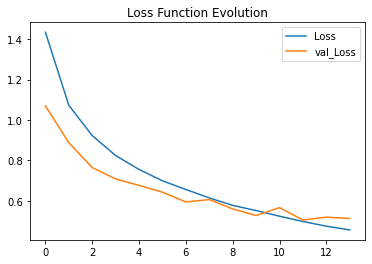

In [22]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

In [23]:
model.evaluate(val_input, val_target)

169/169 [==============================] - 1s 5ms/step - loss: 0.5043 - accuracy: 0.8380


[0.5043334364891052, 0.8379629850387573]

# 테스트 데이터 사용

In [25]:
x_test.shape, y_test.shape

((6000, 32, 32, 3), (6000, 1))

In [28]:
y_pred = model.predict(x_test)

188/188 [==============================] - 1s 3ms/step


In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

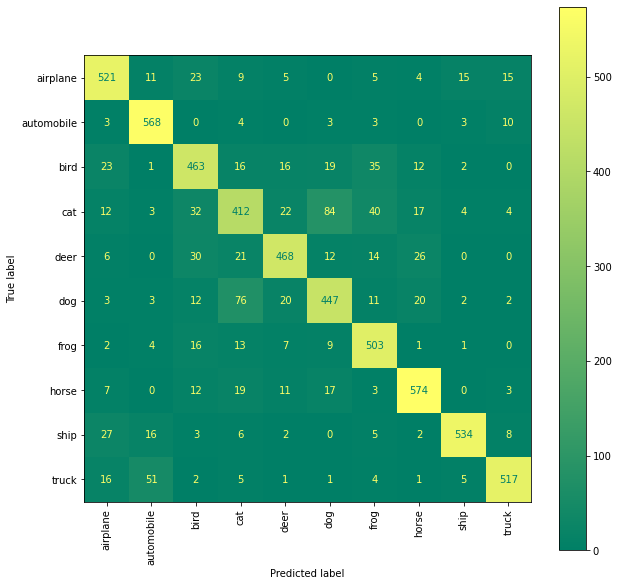

In [37]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

# DenseNet model 사용

In [38]:
from keras.applications.densenet import DenseNet121

model = Sequential()
base_model = DenseNet121(input_shape=(32, 32, 3), include_top=False, weights='imagenet', pooling='avg')
model.add(base_model)
model.add(Dense(num_classes, activation='softmax'))
model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_4 (Dense)             (None, 10)                10250     
                                                                 
Total params: 7,047,754
Trainable params: 6,964,106
Non-trainable params: 83,648
_________________________________________________________________


In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights = True)

history = model.fit(train_input, train_target, batch_size=batch_size, epochs = epochs,
                        shuffle=True, validation_data=(val_input, val_target),
                        steps_per_epoch = steps_per_epoch,
                        callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/50
1518/1518 [==============================] - 102s 59ms/step - loss: 1.2569 - accuracy: 0.5833 - val_loss: 2.6046 - val_accuracy: 0.5111
Epoch 2/50
1518/1518 [==============================] - 84s 54ms/step - loss: 0.9517 - accuracy: 0.6804 - val_loss: 1.1669 - val_accuracy: 0.6248
Epoch 3/50
1518/1518 [==============================] - 82s 54ms/step - loss: 0.8526 - accuracy: 0.7165 - val_loss: 0.8355 - val_accuracy: 0.7139
Epoch 4/50
1518/1518 [==============================] - 88s 58ms/step - loss: 1.3395 - accuracy: 0.5515 - val_loss: 1.7756 - val_accuracy: 0.5335
Epoch 5/50
1518/1518 [==============================] - 84s 55ms/step - loss: 1.1403 - accuracy: 0.6079 - val_loss: 20.8080 - val_accuracy: 0.3385


- DenseNet 모델을 사용해봤으나, 성능이 좋지 않음. 모델에 대한 이해도가 부족해서 그런거 같다.

- https://deep-learning-study.tistory.com/528